✅ 所有模块导入成功！
1. 测试信号生成...
   生成 1000 个数据点
2. 测试噪声添加...
   原始信号范围: [0.413, 1.599]
   加噪信号范围: [0.359, 1.631]
3. 测试相位提取...
4. 测试绘图功能...
💾 干涉图已保存: data/example_output/interferogram.png


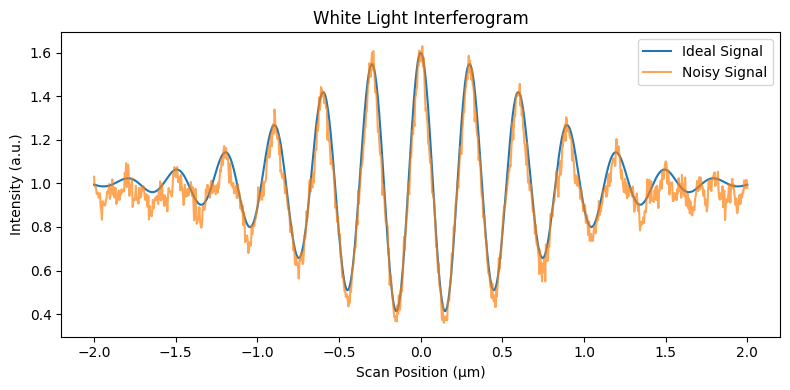

💾 相位图已保存: data/example_output/phase_comparison.png


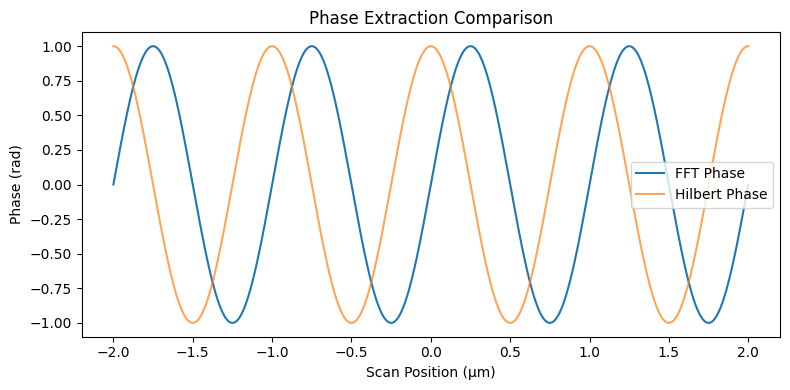

5. 测试3D表面图...
💾 表面图已保存: data/example_output/reconstructed_surface.png


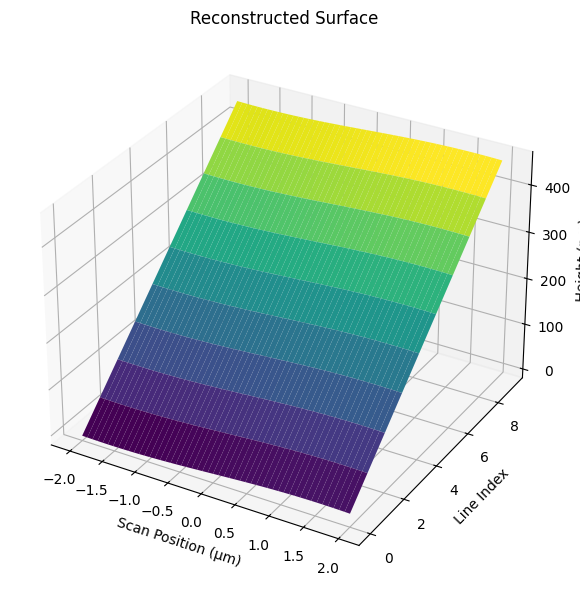


🎉 所有测试完成！
📁 干涉图: None
📁 相位图: None
📁 表面图: None

📸 显示生成的图片:


ValueError: No image data found. Expecting filename, url, or data.

In [41]:
# 在 notebook 中测试所有模块
import sys
import os
sys.path.append('./src')  # 添加 src 目录到路径

# 导入所有模块
from signal_generator import simulate_wsi_signal
from noise_model import add_noise
from visualization import plot_interferogram, plot_phase, plot_surface

import numpy as np
import matplotlib.pyplot as plt

print("✅ 所有模块导入成功！")

# 测试信号生成
print("1. 测试信号生成...")
z_scan = np.linspace(-2e-6, 2e-6, 1000)  # 扫描位置 (m)
I_ideal = simulate_wsi_signal(z_scan)
print(f"   生成 {len(I_ideal)} 个数据点")

# 测试噪声添加 - 修复这里！
print("2. 测试噪声添加...")
I_noisy = add_noise(I_ideal, z_scan)  # 只接收一个返回值
print(f"   原始信号范围: [{I_ideal.min():.3f}, {I_ideal.max():.3f}]")
print(f"   加噪信号范围: [{I_noisy.min():.3f}, {I_noisy.max():.3f}]")

# 测试相位提取（简单示例）
print("3. 测试相位提取...")
# 这里用简单的正弦波模拟相位
phase_fft = np.sin(2 * np.pi * z_scan / 1e-6)
phase_hilbert = np.cos(2 * np.pi * z_scan / 1e-6)

# 测试绘图功能
print("4. 测试绘图功能...")
interferogram_path = plot_interferogram(z_scan, I_ideal, I_noisy)
phase_path = plot_phase(z_scan, phase_fft, phase_hilbert)

# 测试3D表面图
print("5. 测试3D表面图...")
# 创建示例表面数据
x_lines = np.arange(10)  # 10条线
y_positions = z_scan  # 扫描位置
# 创建一个简单的斜面高度图
height_map = np.array([(i * 50e-9 + np.sin(y_positions * 1e6) * 10e-9) for i in range(10)])

surface_path = plot_surface(x_lines, y_positions, height_map)

print("\n🎉 所有测试完成！")
print(f"📁 干涉图: {interferogram_path}")
print(f"📁 相位图: {phase_path}")
print(f"📁 表面图: {surface_path}")

# 在 notebook 中显示图片
from IPython.display import Image, display
print("\n📸 显示生成的图片:")
display(Image(filename=interferogram_path))
display(Image(filename=phase_path)) 
display(Image(filename=surface_path))

✅ 所有模块导入成功！
1. 测试信号生成...
2. 测试噪声添加...
3. 测试相位提取...
4. 测试绘图功能...
💾 干涉图已保存: data/example_output/interferogram.png


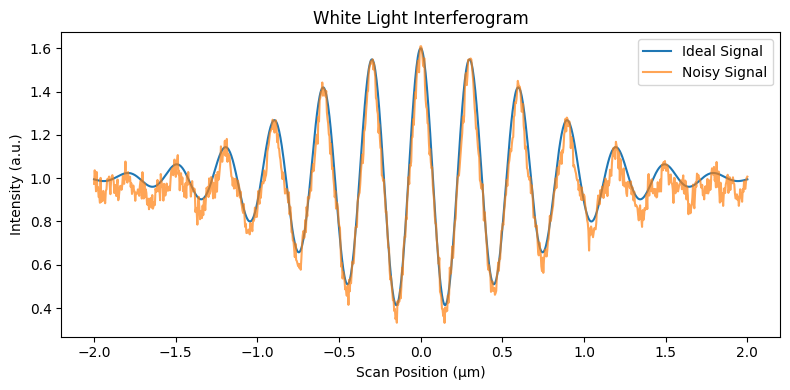

💾 相位图已保存: data/example_output/phase_comparison.png


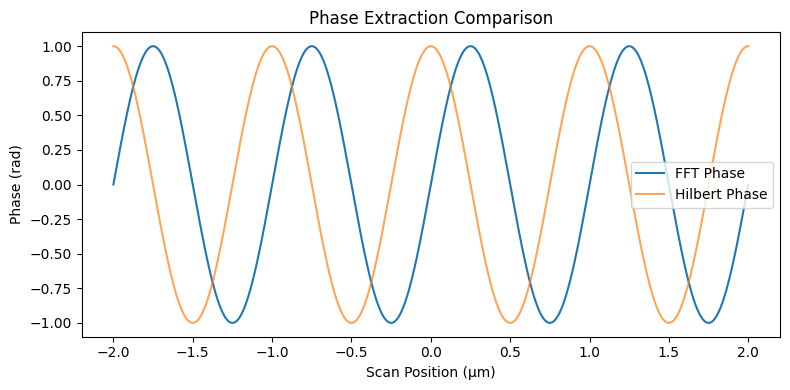

5. 测试3D表面图...
💾 表面图已保存: data/example_output/reconstructed_surface.png


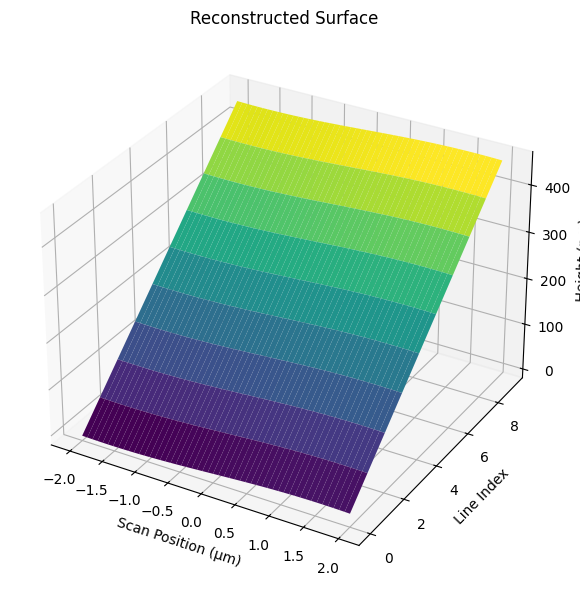


🎉 绘图函数调用完成！

🔍 检查文件是否存在:


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

In [42]:
# 在 notebook 中测试所有模块
import sys
import os
sys.path.append('./src')

from signal_generator import simulate_wsi_signal
from noise_model import add_noise
from visualization import plot_interferogram, plot_phase, plot_surface

import numpy as np
import matplotlib.pyplot as plt

print("✅ 所有模块导入成功！")

# 测试信号生成
print("1. 测试信号生成...")
z_scan = np.linspace(-2e-6, 2e-6, 1000)
I_ideal = simulate_wsi_signal(z_scan)

# 测试噪声添加
print("2. 测试噪声添加...")
I_noisy = add_noise(I_ideal, z_scan)

# 测试相位提取
print("3. 测试相位提取...")
phase_fft = np.sin(2 * np.pi * z_scan / 1e-6)
phase_hilbert = np.cos(2 * np.pi * z_scan / 1e-6)

# 测试绘图功能
print("4. 测试绘图功能...")
interferogram_path = plot_interferogram(z_scan, I_ideal, I_noisy)
phase_path = plot_phase(z_scan, phase_fft, phase_hilbert)

# 测试3D表面图
print("5. 测试3D表面图...")
x_lines = np.arange(10)
y_positions = z_scan
height_map = np.array([(i * 50e-9 + np.sin(y_positions * 1e6) * 10e-9) for i in range(10)])
surface_path = plot_surface(x_lines, y_positions, height_map)

print("\n🎉 绘图函数调用完成！")

# 检查文件是否真的创建了
print("\n🔍 检查文件是否存在:")
for path, name in [(interferogram_path, "干涉图"), 
                   (phase_path, "相位图"), 
                   (surface_path, "表面图")]:
    exists = os.path.exists(path)
    print(f"  {name}: {path} - {'✅ 存在' if exists else '❌ 不存在'}")
    if exists:
        file_size = os.path.getsize(path)
        print(f"    文件大小: {file_size} 字节")

# 只有文件存在时才显示
from IPython.display import Image, display
print("\n📸 显示生成的图片:")
if os.path.exists(interferogram_path):
    display(Image(filename=interferogram_path))
else:
    print("❌ 干涉图文件不存在")

if os.path.exists(phase_path):
    display(Image(filename=phase_path))
else:
    print("❌ 相位图文件不存在")

if os.path.exists(surface_path):
    display(Image(filename=surface_path))
else:
    print("❌ 表面图文件不存在")

✅ 所有模块导入成功！
1. 测试信号生成...
2. 测试噪声添加...
3. 测试绘图功能...
调用 plot_interferogram...
💾 干涉图已保存: data/example_output/interferogram.png


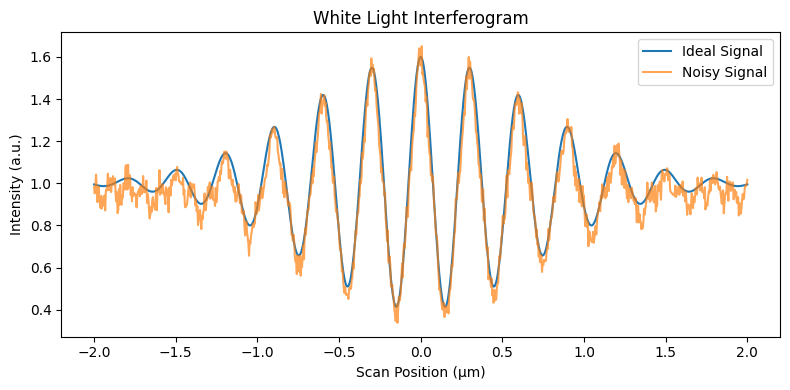

干涉图函数返回: None (类型: <class 'NoneType'>)
调用 plot_phase...
💾 相位图已保存: data/example_output/phase_comparison.png


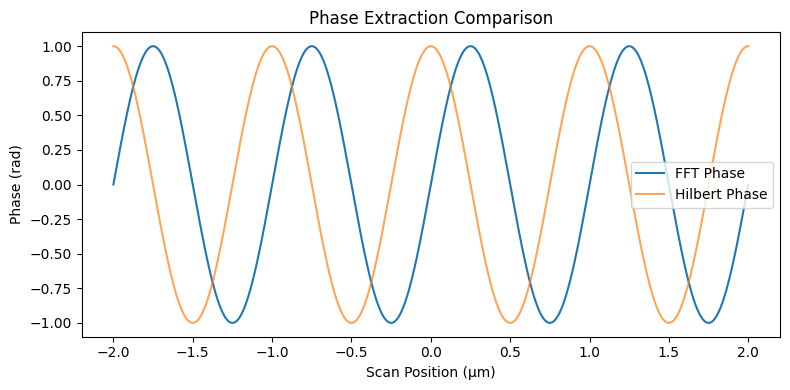

相位图函数返回: None (类型: <class 'NoneType'>)
调用 plot_surface...
💾 表面图已保存: data/example_output/reconstructed_surface.png


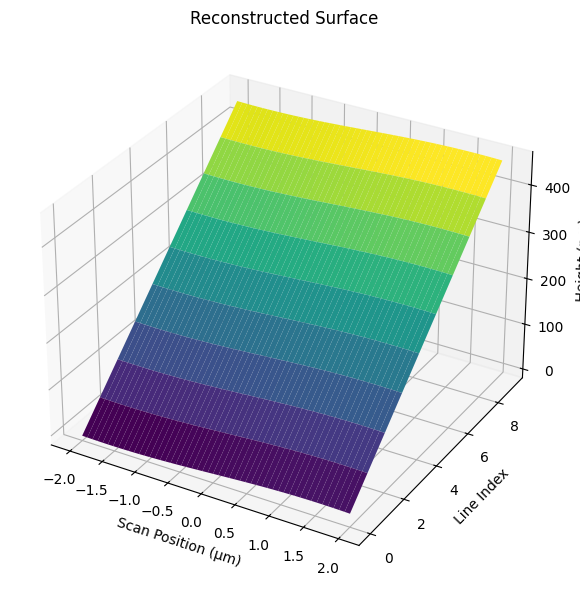

表面图函数返回: None (类型: <class 'NoneType'>)

🔍 检查文件是否存在:


In [43]:
# 在 notebook 中诊断
import sys
import os
sys.path.append('./src')

from signal_generator import simulate_wsi_signal
from noise_model import add_noise
from visualization import plot_interferogram, plot_phase, plot_surface

import numpy as np
import matplotlib.pyplot as plt

print("✅ 所有模块导入成功！")

# 测试信号生成
print("1. 测试信号生成...")
z_scan = np.linspace(-2e-6, 2e-6, 1000)
I_ideal = simulate_wsi_signal(z_scan)

# 测试噪声添加
print("2. 测试噪声添加...")
I_noisy = add_noise(I_ideal, z_scan)

# 测试绘图功能 - 检查返回值
print("3. 测试绘图功能...")
print("调用 plot_interferogram...")
interferogram_path = plot_interferogram(z_scan, I_ideal, I_noisy)
print(f"干涉图函数返回: {interferogram_path} (类型: {type(interferogram_path)})")

print("调用 plot_phase...")
phase_fft = np.sin(2 * np.pi * z_scan / 1e-6)
phase_hilbert = np.cos(2 * np.pi * z_scan / 1e-6)
phase_path = plot_phase(z_scan, phase_fft, phase_hilbert)
print(f"相位图函数返回: {phase_path} (类型: {type(phase_path)})")

print("调用 plot_surface...")
x_lines = np.arange(10)
y_positions = z_scan
height_map = np.array([(i * 50e-9 + np.sin(y_positions * 1e6) * 10e-9) for i in range(10)])
surface_path = plot_surface(x_lines, y_positions, height_map)
print(f"表面图函数返回: {surface_path} (类型: {type(surface_path)})")

# 只有返回值不是 None 时才检查文件
print("\n🔍 检查文件是否存在:")
paths_to_check = []
if interferogram_path is not None:
    paths_to_check.append((interferogram_path, "干涉图"))
if phase_path is not None:
    paths_to_check.append((phase_path, "相位图")) 
if surface_path is not None:
    paths_to_check.append((surface_path, "表面图"))

for path, name in paths_to_check:
    exists = os.path.exists(path)
    print(f"  {name}: {path} - {'✅ 存在' if exists else '❌ 不存在'}")
    if exists:
        file_size = os.path.getsize(path)
        print(f"    文件大小: {file_size} 字节")

✅ 所有模块导入成功！
1. 测试干涉图...
💾 干涉图已保存: data/example_output/interferogram.png


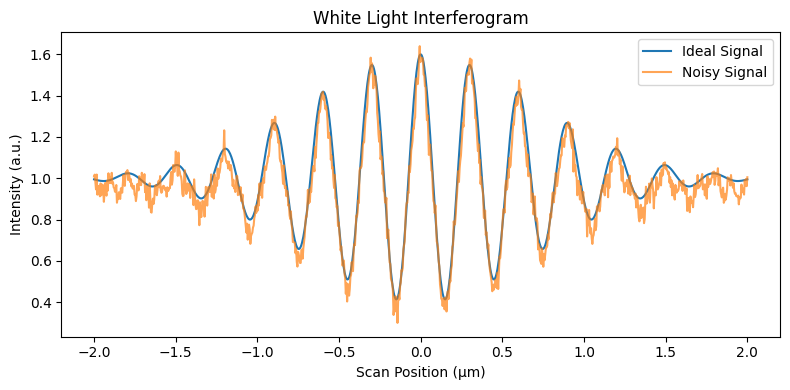

✅ 干涉图成功: None

2. 测试相位图...
💾 相位图已保存: data/example_output/phase_comparison.png


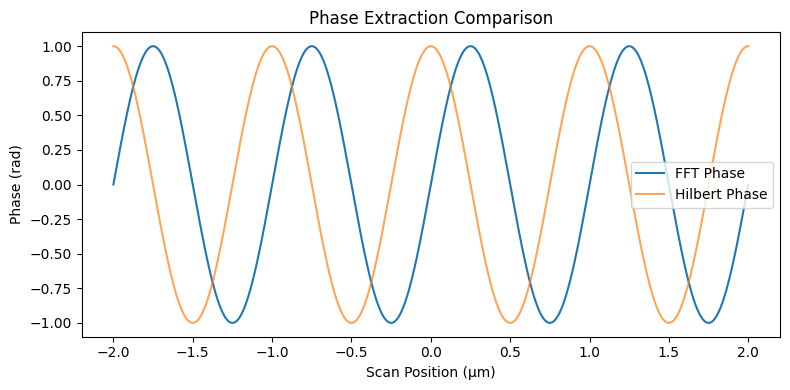

✅ 相位图成功: None

3. 测试表面图...
x_lines shape: (10,)
y_positions shape: (1000,)
height_map shape: (10, 1000)
💾 表面图已保存: data/example_output/reconstructed_surface.png


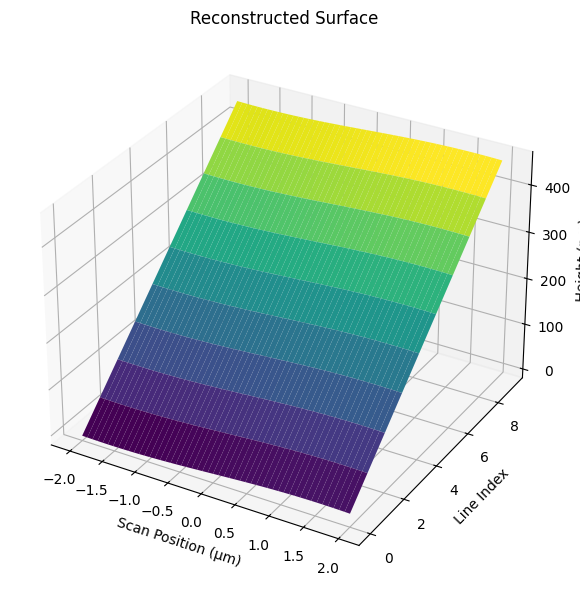

✅ 表面图成功: None


In [44]:
# 单独测试每个绘图函数
import sys
import os
sys.path.append('./src')

from signal_generator import simulate_wsi_signal
from noise_model import add_noise
from visualization import plot_interferogram, plot_phase, plot_surface

import numpy as np
import matplotlib.pyplot as plt

print("✅ 所有模块导入成功！")

# 生成测试数据
z_scan = np.linspace(-2e-6, 2e-6, 1000)
I_ideal = simulate_wsi_signal(z_scan)
I_noisy = add_noise(I_ideal, z_scan)
phase_fft = np.sin(2 * np.pi * z_scan / 1e-6)
phase_hilbert = np.cos(2 * np.pi * z_scan / 1e-6)

# 单独测试每个函数
print("1. 测试干涉图...")
try:
    interferogram_path = plot_interferogram(z_scan, I_ideal, I_noisy)
    print(f"✅ 干涉图成功: {interferogram_path}")
except Exception as e:
    print(f"❌ 干涉图失败: {e}")

print("\n2. 测试相位图...")
try:
    phase_path = plot_phase(z_scan, phase_fft, phase_hilbert)
    print(f"✅ 相位图成功: {phase_path}")
except Exception as e:
    print(f"❌ 相位图失败: {e}")

print("\n3. 测试表面图...")
try:
    x_lines = np.arange(10)
    y_positions = z_scan
    height_map = np.array([(i * 50e-9 + np.sin(y_positions * 1e6) * 10e-9) for i in range(10)])
    
    print(f"x_lines shape: {x_lines.shape}")
    print(f"y_positions shape: {y_positions.shape}") 
    print(f"height_map shape: {height_map.shape}")
    
    surface_path = plot_surface(x_lines, y_positions, height_map)
    print(f"✅ 表面图成功: {surface_path}")
except Exception as e:
    print(f"❌ 表面图失败: {e}")
    import traceback
    traceback.print_exc()